# Federated Learning (FL) - Titanic

## Objective
Train a ML model to predict the survival probability in a federated setup and benchmark it against a model being trained on the full dataset.

## Import packages

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, ConfusionMatrixDisplay

In [2]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

# add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src import config
from src import client
from src import data
from src import preprocess
from src import model
from src import server
from src import stats
from src import visual
from src import utils

## Set-up server
The server contains one or more collaborations. It orchestrates the movement of algorithms between clients and aggregates the results.

Here we initialize a Server set up for the Titanic use case. All algorithms part of the Server's collaboration are distributed to each respective client.

In [4]:
server_titanic = config.ServerTitanic()
server_titanic

All algorithms are distributed to clients successfully


ServerTitanic(
       collab=CollaborationTitanic()
)

A collaboration consists of:
1. clients: data owners
2. statistics: statistical functions 
3. transformers: transformer pipeline to pre-process the data prior to training the classifier
4. classsifer: classifier trained on local datasets
5. classifier_aggregator: strategy to combine classifier results
6. statistics_aggregators: methods to combine statistical results

In [7]:
server_titanic.collab

CollaborationTitanic(
       clients=[ClientA(), ClientB()], 
       statistics={count_records=CountRecords(), nominal_categories=ColumnCategories(), target_classes=ColumnCategories()}, 
       transformers=Pipeline(), 
       classifier=BatchSGD(), 
       classifier_aggregator=FedAvg(), 
       statistics_aggregators={count_records=SumValues(), nominal_categories=NestedListUnion(), target_classes=ListUnion()}
)

Clients have a pointer to the data they have stored locally. They also store a local version of all algorithms defined in the collab and can run these on their local data.

In [8]:
server_titanic.collab.clients[0]

ClientA(
       name=A, 
       data_pointer=DataA(), 
       clf_local=BatchSGD(), 
       transformers=Pipeline(), 
       statistics={count_records=CountRecords(), nominal_categories=ColumnCategories(), target_classes=ColumnCategories()}, 
       clf_scores_={clf_scores_={'local_scores': [], 'global_scores': []}, clf_scores_={'local_scores': [], 'global_scores': []}}, 
       clf_results_={}
)

## Run statistics

The following statistics are run on the local datasets. These statistics can give a summary of the data, but are also used in the next section to update parameters in the transformers, classifiers and aggregation strategy.
- count_records: used to set the weights of the classifier aggregation, to give more weight to updates from clients that trained their data on larger datasets.
- nominal_categories: merges all column categories in the nominal columns of all client's datasets, where each local dataset might have distinct categories. This information can be used by a one-hot-encoding step in the transformer pipeline to ensure columns are created for all possible categories.
- target_classes: merges all possible target classes to ensure that both clients have all possible targets to be predicted.

In [9]:
server_titanic.collab.statistics

{'count_records': CountRecords(),
 'nominal_categories': ColumnCategories(
        column_names=[Sex, Embarked], 
        flatten_list=False
 ),
 'target_classes': ColumnCategories(
        column_names=[Survived], 
        flatten_list=True
 )}

It uses the following strategies to combine the local statistic results, to get a statistics of the combined data.

In [10]:
server_titanic.collab.statistics_aggregators

{'count_records': SumValues(),
 'nominal_categories': NestedListUnion(
        unique=True
 ),
 'target_classes': ListUnion(
        unique=True
 )}

Using the following function, the servers orders all clients to run the statistical methods on their local data and subsequently aggregates them.

In [11]:
server_titanic.run_statistics()

ServerTitanic(
       collab=CollaborationTitanic()
)

This way we inspect the local statistic results, for example a count of the number of records for the data provided by each client.

In [12]:
server_titanic.collab.clients[0].statistics['count_records']

CountRecords(
       results_=244
)

In [13]:
server_titanic.collab.clients[1].statistics['count_records']

CountRecords(
       results_=468
)

And here we see the combined results, when summing the number of records for all clients.

In [14]:
server_titanic.collab.statistics['count_records']

CountRecords(
       results_=712
)

## Train Federated Classifier

The server can order all clients to transform their data and train their classifier locally. It uses the following transformer pipeline and classifier.

In [15]:
server_titanic.collab.transformers

Pipeline(steps=[('preprocess',
                 GenericPreprocessor(features_continuous=['Age', 'Fare'],
                                     features_drop=['PassengerId', 'pred',
                                                    'Name', 'Ticket', 'Cabin'],
                                     features_nominal=['Sex', 'Embarked'],
                                     features_ordinal=['Pclass', 'SibSp',
                                                       'Parch'])),
                ('scale', RobustScaler())])

BatchSGD is a subclass of the sklearn SGDCLassifier, which can use stochastic gradient descent to train on batches of data instead of single examples. The loss parameter allows the user to select different classifiers, for example a logistic regression (using 'log_loss') or linear SVM (using 'hinge').

In [16]:
server_titanic.collab.classifier

BatchSGD(batch_size=20, loss='log_loss', n_local_iterations=100,
         random_state=42)

In [17]:
server_titanic.fit_classifier()

The above function automatically averages the results using the strategy below. Note the weights are derived from the 'count_records' statistic computed earlier.

In [18]:
server_titanic.collab.classifier_aggregator

FedAvg(
       n_iterations=20, 
       weights=[0.34269663 0.65730337]
)

## Training a centralized model
For comparison, we also train a centralized model with the same configurations as specified in the Federated set-up, but where we first combine the data from each client and then train a classifier.

In [19]:
def combine_dataset():
    # load data files of each party
    data_a = config.DataA()
    X_train_a, y_train_a = data_a.load_train_data(split_xy=True)
    X_test_a, y_test_a = data_a.load_test_data(split_xy=True)

    data_b = config.DataB()
    X_train_b, y_train_b = data_b.load_train_data(split_xy=True)
    X_test_b, y_test_b = data_b.load_test_data(split_xy=True)

    # join data files
    X_train = pd.concat([X_train_a, X_train_b])
    X_test = pd.concat([X_test_a, X_test_b])
    y_train = pd.concat([y_train_a, y_train_b])
    y_test = pd.concat([y_test_a, y_test_b])

    return X_train, X_test, y_train, y_test

def train_centralized_model(X_train, y_train, X_test, y_test):
    """Train model when data is first is centralized (i.e. combined)"""

    # load transformer pipeline and classifier 
    pipeline = model.get_standard_transformer_pipeline(features_drop=config.FEATURES_DROP,
                                                       features_nominal=config.FEATURES_NOMINAL,
                                                       features_ordinal=config.FEATURES_ORDINAL,
                                                       features_continuous=config.FEATURES_INTERVAL+config.FEATURES_RANGE, 
                                                       categories='auto')
    classifier = model.get_standard_classifier(random_state=config.RANDOM_STATE)

    # merge classifier to pipeline
    pipeline.steps.append(('clf', classifier))
    
    # train model store scores each iteration
    scores = []
    for n in range(config.N_GLOBAL_ITERATIONS):
        pipeline.fit(X_train, y_train)
        scores.append(pipeline.score(X_test, y_test))
    return pipeline, scores


X_train, X_test, y_train, y_test = combine_dataset()
clf_central, scores_central = train_centralized_model(X_train, y_train, X_test, y_test)

## Evaluate results

Before comparing the results, we first need to run the following function for the server to order each client to perform some evaluation steps

In [20]:
server_titanic.evaluate_classifier()

Below we the results from testing the global classifier on each data party's local test data.

In [123]:
server_titanic.collab.clf_results_

{'A': {'accuracy': 0.7903225806451613,
  'roc_auc_score': 0.7761904761904761,
  'average_precision': 0.690615835777126,
  'confusion_matrix': array([[31,  4],
         [ 9, 18]], dtype=int64)},
 'B': {'accuracy': 0.8034188034188035,
  'roc_auc_score': 0.7261904761904762,
  'average_precision': 0.648962148962149,
  'confusion_matrix': array([[75,  0],
         [23, 19]], dtype=int64)}}

Here we compute the results of the centralized model

In [124]:
y_pred = clf_central.predict(X_test)
print(f'accuracy score centralized: {accuracy_score(y_test, y_pred)}')
print(f'roc auc score centralized: {roc_auc_score(y_test, y_pred)}')
print(f'average precision score centralized: {average_precision_score(y_test, y_pred)}')

accuracy score centralized: 0.7877094972067039
roc auc score centralized: 0.7678524374176547
average precision score centralized: 0.6310715795777734


We can get the scores from the server that were computed at each iteration and merge these with the scores from the centralized model for comparison

In [125]:
df_classifier_scores = server_titanic.collab.merge_classifier_scores(output_df=True)
df_classifier_scores['Centralized'] = scores_central
df_classifier_scores.head()

,A.local_scores,A.global_scores,B.local_scores,B.global_scores,Centralized
0,0.709677,0,0.803419,0,0.770950
1,0.725806,0.790323,0.811966,0.74359,0.793296
2,0.709677,0.693548,0.803419,0.794872,0.776536
3,0.725806,0.709677,0.717949,0.735043,0.765363
4,0.774194,0.774194,0.786325,0.735043,0.776536


Local scores refer to model that were tested just after re-training.
Global scores refer to models that were tested just after averaging the local models

We observe very similar scores between all of the models. It's notable that the Centralized model is more stable then the federated models. Also the modesl from party B seem more stable than the models from party A, likely due to the fact that party B has 2x the amount of records. 

Nevertheless, the results between centralized and federated seem very similar.

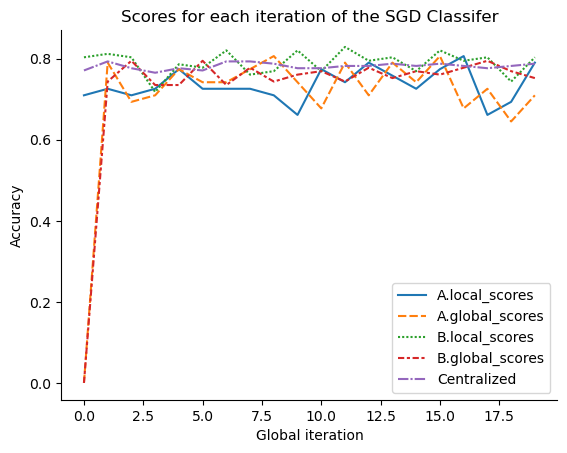

In [126]:
ax = sns.lineplot(df_classifier_scores)
sns.despine()
ax.set_xlabel('Global iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Scores for each iteration of the SGD Classifer')
plt.show()

We can also look ath the confusion matices for each model below.

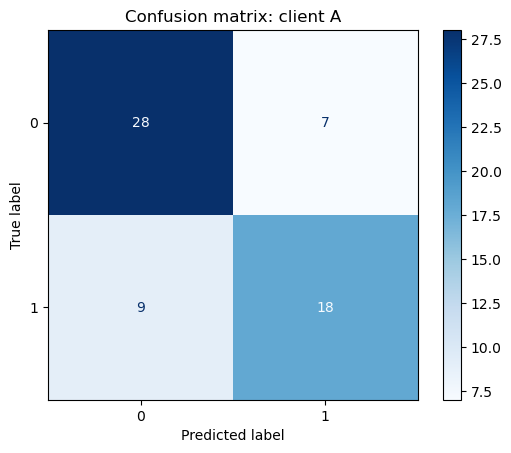

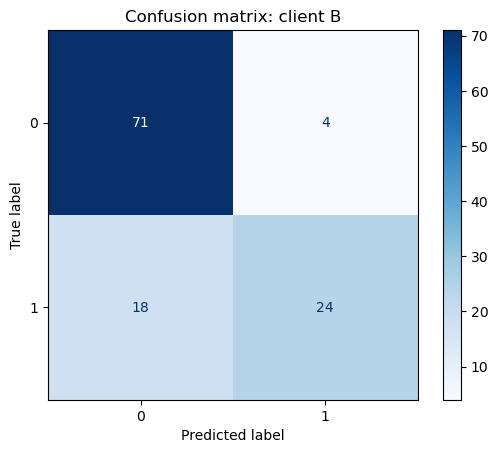

In [84]:
for client_name, results in server_titanic.collab.clf_results_.items():
    cmd = visual.plot_confusion_matrix(results['confusion_matrix'])
    plt.title(f'Confusion matrix: client {client_name}')


Text(0.5, 1.0, 'Confusion matrix: centralized model')

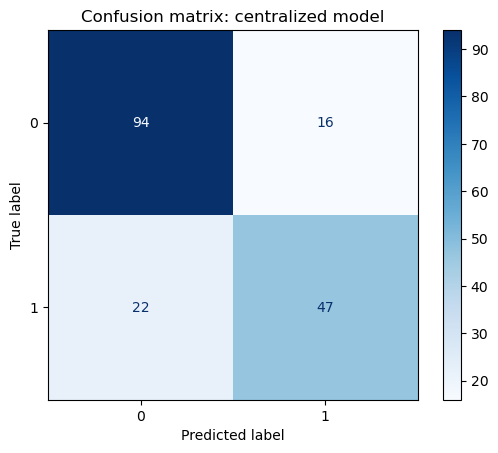

In [88]:
y_pred_central = clf_central.predict(X_test)
cm_central = confusion_matrix(y_test, y_pred_central)
visual.plot_confusion_matrix(cm_central)
plt.title('Confusion matrix: centralized model')

# Conclusion
In this notebook, we showed how you can use the FL framework in this repo to train a ML model on the titanic dataset. We also compared it to a model trained on a centralized dataset. Fortunately, the results seem very similar, thus one can use federated ML to get virtually identical results to models trained on centralized data!